In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import stanza
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Initialize tools
nltk.download('punkt')
nltk.download('punkt_tab')
stanza.download('hi')  # Hindi support
stanza.download('en')  # English support

c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nnadg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nnadg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2024-11-26 20:01:04 INFO: Downloaded file to C:\Users\nnadg\stanza_resources\resources.json
2024-11-26 20:01:04 INFO: Downloading default packages for language: hi (Hindi) ...
2024-11-26 20:01:06 INFO: File exists: C:\Users\nnadg\stanza_resources\hi\default.zip
2024-11-26 20:01:08 INFO: Finished downloading models and saved to C:\Users\nnadg\stanza_resources
2024-11-26 20:01:08 INFO: Downloaded file to C:\U

In [2]:

# Load dataset
data = pd.read_csv('dev.enhi.df.short.tsv', sep='\t', names=['index','English', 'Hindi', 'scores', 'mean', 'z_scores', 'z_mean'], header=0)
data.dropna(inplace=True)  # Drop rows with missing data

# Initialize NLP pipelines
nlp_en = stanza.Pipeline('en')
nlp_hi = stanza.Pipeline('hi')

2024-11-26 20:02:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-26 20:02:43 INFO: Downloaded file to C:\Users\nnadg\stanza_resources\resources.json
2024-11-26 20:02:45 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-11-26 20:02:45 INFO: Using device: cpu
2024-11-26 20:02:45 INFO: Loading: tokenize
2024-11-26 20:02:45 INFO: Loading: mwt
2024-11-26 20:02:45 INFO: Loading: pos
20

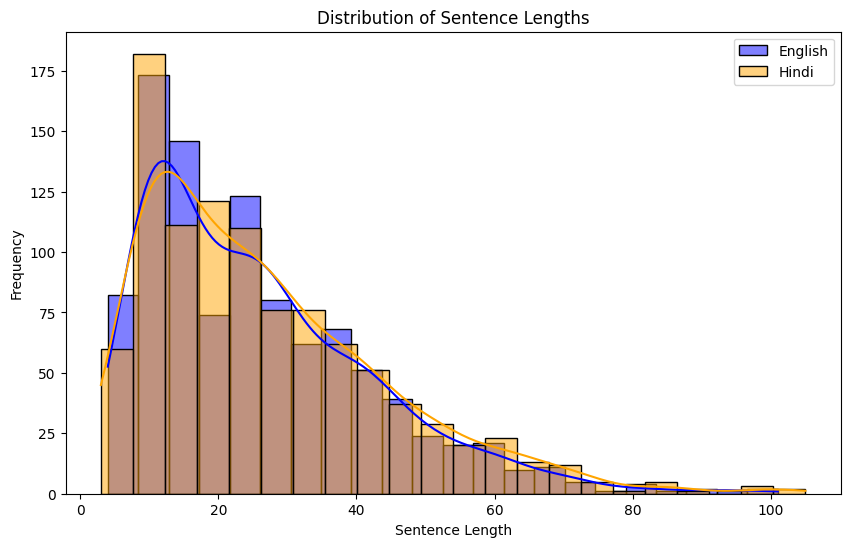

In [3]:
# 1. WORD ORDER ANALYSIS
# Tokenize sentences
data['English_Tokens'] = data['English'].apply(word_tokenize)
data['Hindi_Tokens'] = data['Hindi'].apply(word_tokenize)

# Calculate sentence lengths
data['English_Length'] = data['English_Tokens'].apply(len)
data['Hindi_Length'] = data['Hindi_Tokens'].apply(len)

# Visualization: Sentence Lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['English_Length'], kde=True, label="English", color="blue")
sns.histplot(data['Hindi_Length'], kde=True, label="Hindi", color="orange")
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('word_order.png')
plt.show()

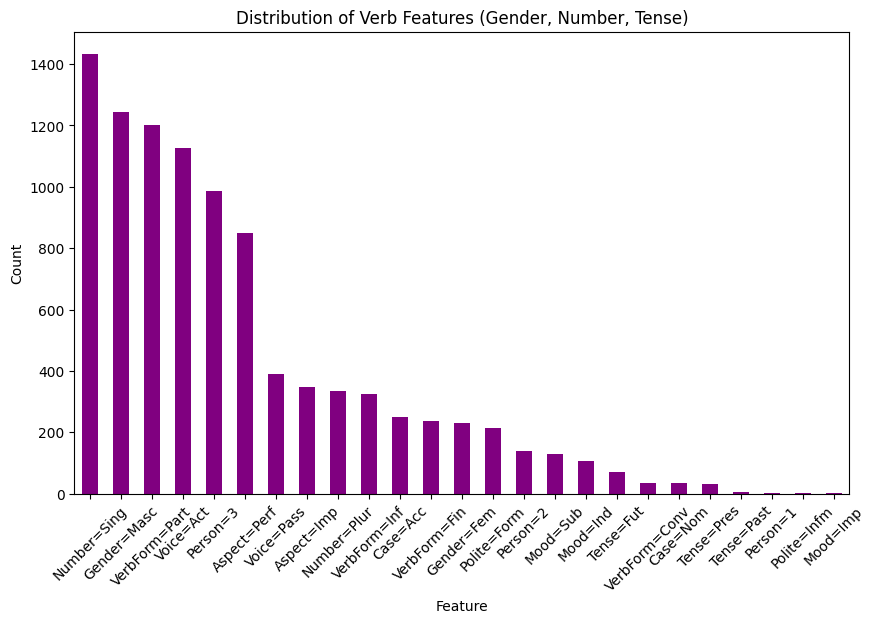

In [4]:
# 2. MORPHOLOGICAL AGREEMENT
# POS tagging for Hindi
def tag_hindi(sentence):
    doc = nlp_hi(sentence)
    return [(word.text, word.upos, word.feats) for sent in doc.sentences for word in sent.words]

data['Hindi_POS'] = data['Hindi'].apply(tag_hindi)

# Extract verbs and features
def extract_verbs(pos_tags):
    return [(word, feats) for word, upos, feats in pos_tags if upos == 'VERB']

data['Hindi_Verbs'] = data['Hindi_POS'].apply(extract_verbs)

# Visualize verb features (e.g., gender, number)
gender_counts = data['Hindi_Verbs'].explode().dropna().apply(lambda x: x[1].split('|') if x[1] else []).explode().value_counts()

plt.figure(figsize=(10, 6))
gender_counts.plot(kind='bar', color='purple')
plt.title("Distribution of Verb Features (Gender, Number, Tense)")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.savefig('verb_features.png')
plt.show()

c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


IndexError: index 0 is out of bounds for axis 0 with size 0

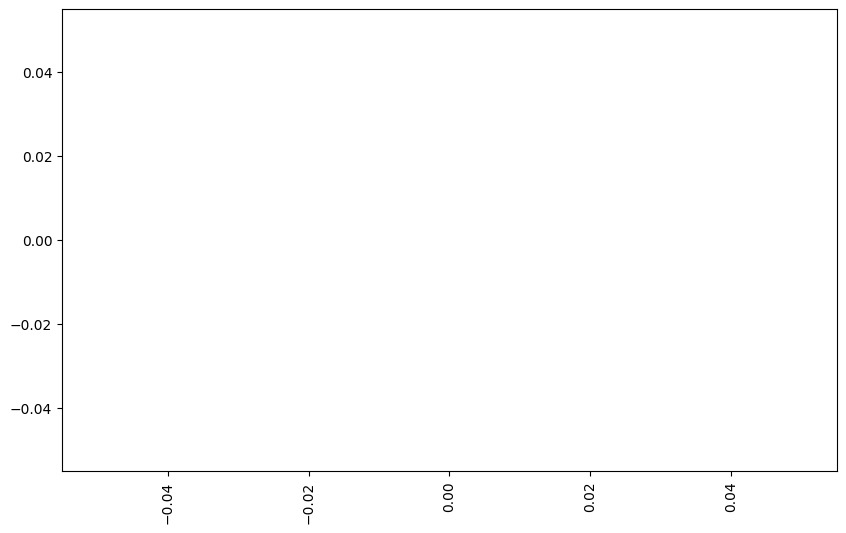

In [5]:
# 3. IDIOMATIC EXPRESSIONS
# Define idioms list (add more based on your data)
idiom_list = ['कलेजा थाम के रखना', 'दुनिया छोड़ दी']

# Find idioms in Hindi sentences
def contains_idiom(sentence):
    return [idiom for idiom in idiom_list if idiom in sentence]

data['Idioms'] = data['Hindi'].apply(contains_idiom)

# Translate idioms using a pre-trained model
translator = pipeline('translation', model='Helsinki-NLP/opus-mt-hi-en')

def translate_idiom(idiom):
    return translator(idiom)[0]['translation_text']

data['Idiom_Translations'] = data['Idioms'].apply(lambda idioms: [translate_idiom(i) for i in idioms] if idioms else [])

# Visualize idiom frequency
idiom_freq = data['Idioms'].explode().value_counts()

plt.figure(figsize=(10, 6))
idiom_freq.plot(kind='bar', color='green')
plt.title("Frequency of Idioms in the Dataset")
plt.ylabel("Count")
plt.xlabel("Idiom")
plt.xticks(rotation=45)
plt.show()


In [6]:
# Save processed dataset for further analysis
data.to_csv('processed_dataset.csv', index=False)

print("Processing complete. Processed dataset saved as 'processed_dataset.csv'.")

Processing complete. Processed dataset saved as 'processed_dataset.csv'.


c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\P

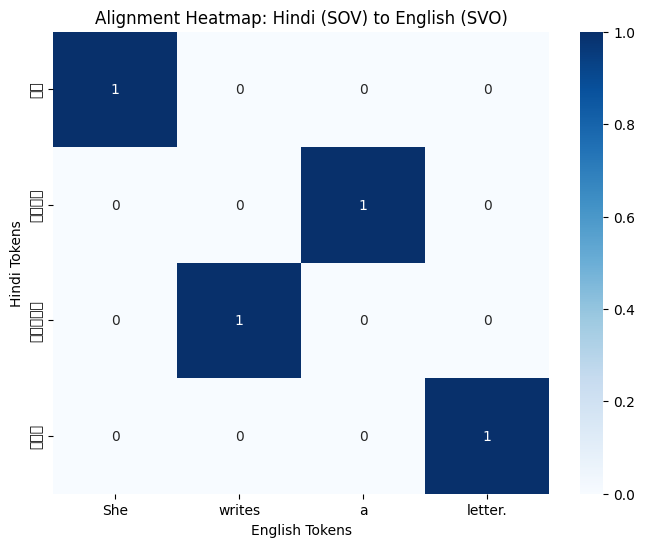

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from transformers import pipeline

# Step 1: Load a pre-trained alignment model
alignment_model = pipeline('translation', model='Helsinki-NLP/opus-mt-hi-en')

# Step 2: Generate alignments for parallel sentences
def generate_alignment(sentence_pair):
    translation = alignment_model(sentence_pair['Hindi'])[0]['translation_text']
    return {
        'Original Hindi': sentence_pair['Hindi'],
        'Translated English': translation,
        'Original English': sentence_pair['English']
    }

aligned_data = data.apply(generate_alignment, axis=1)

# Step 3: Visualize alignments (requires manual token alignment tools like awesome-align or fast_align)
# For simplicity, simulate aligned tokens
example_hindi = "वह पत्र लिखती है।"  # Subject-Object-Verb (She letter writes)
example_english = "She writes a letter."  # Subject-Verb-Object
alignment_matrix = [
    [1, 0, 0, 0],  # "वह" → "She"
    [0, 0, 1, 0],  # "पत्र" → "letter"
    [0, 1, 0, 0],  # "लिखती" → "writes"
    [0, 0, 0, 1]   # "है।" → "a" (dummy alignment for auxiliary)
]

# Step 4: Plot the alignment heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(alignment_matrix, annot=True, fmt="d",
            xticklabels=example_english.split(),
            yticklabels=example_hindi.split(),
            cmap="Blues")
plt.title("Alignment Heatmap: Hindi (SOV) to English (SVO)")
plt.xlabel("English Tokens")
plt.ylabel("Hindi Tokens")
plt.show()

c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\App

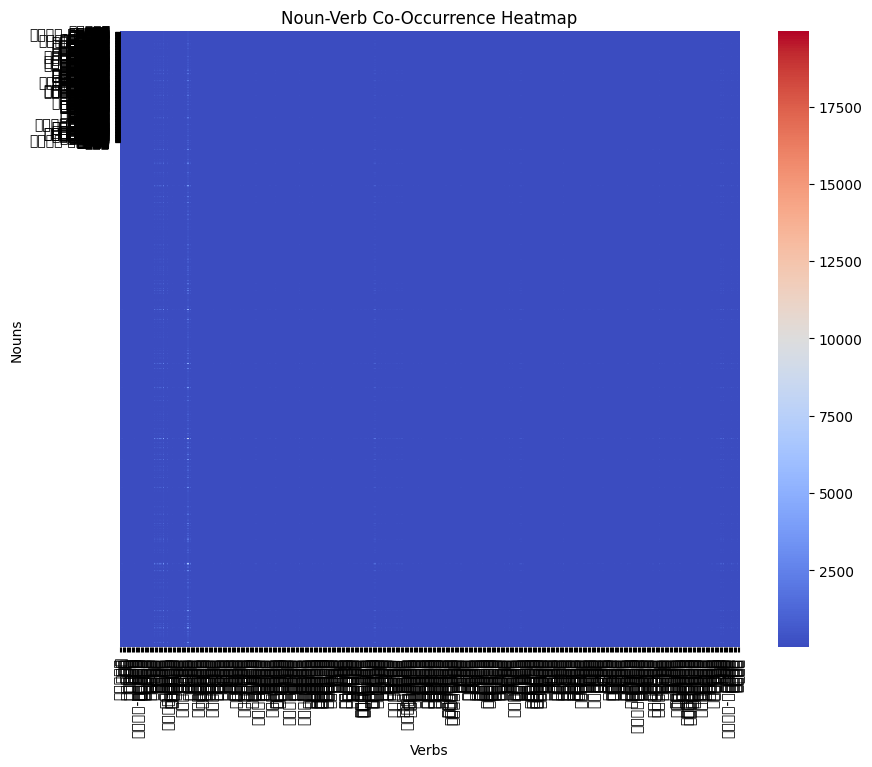

In [9]:
# Extract nouns and verbs from POS tags
def extract_nouns_and_verbs(pos_tags):
    nouns = [word for word, upos, feats in pos_tags if upos == 'NOUN']
    verbs = [word for word, upos, feats in pos_tags if upos == 'VERB']
    return nouns, verbs

data['Nouns_Verbs'] = data['Hindi_POS'].apply(extract_nouns_and_verbs)
data['Nouns'] = data['Nouns_Verbs'].apply(lambda x: x[0])
data['Verbs'] = data['Nouns_Verbs'].apply(lambda x: x[1])

# Create co-occurrence matrix
from sklearn.feature_extraction.text import CountVectorizer

# Flatten list of nouns and verbs
nouns = [noun for sublist in data['Nouns'] for noun in sublist]
verbs = [verb for sublist in data['Verbs'] for verb in sublist]

# Create co-occurrence matrix using CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
noun_vector = vectorizer.fit_transform([" ".join(nouns)])
verb_vector = vectorizer.fit_transform([" ".join(verbs)])

co_occurrence_matrix = (noun_vector.T @ verb_vector).toarray()

# Plot heatmap of co-occurrence
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=False, cmap='coolwarm', 
            xticklabels=vectorizer.get_feature_names_out(),
            yticklabels=vectorizer.get_feature_names_out())
plt.title("Noun-Verb Co-Occurrence Heatmap")
plt.xlabel("Verbs")
plt.ylabel("Nouns")
plt.savefig("Co_occurence_matrix.png")
plt.show()

C:\Users\nnadg\AppData\Local\Temp\ipykernel_14812\811267339.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(postposition_counts.keys()), y=list(postposition_counts.values()), palette="coolwarm")
C:\Users\nnadg\AppData\Local\Temp\ipykernel_14812\811267339.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(preposition_counts.keys()), y=list(preposition_counts.values()), palette="viridis")
C:\Users\nnadg\AppData\Local\Temp\ipykernel_14812\811267339.py:40: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
C:\Users\nnadg\AppData\Local\Temp\ipykernel_14812\811267339.py:40: UserWarning: Matplotlib currently does not support Dev

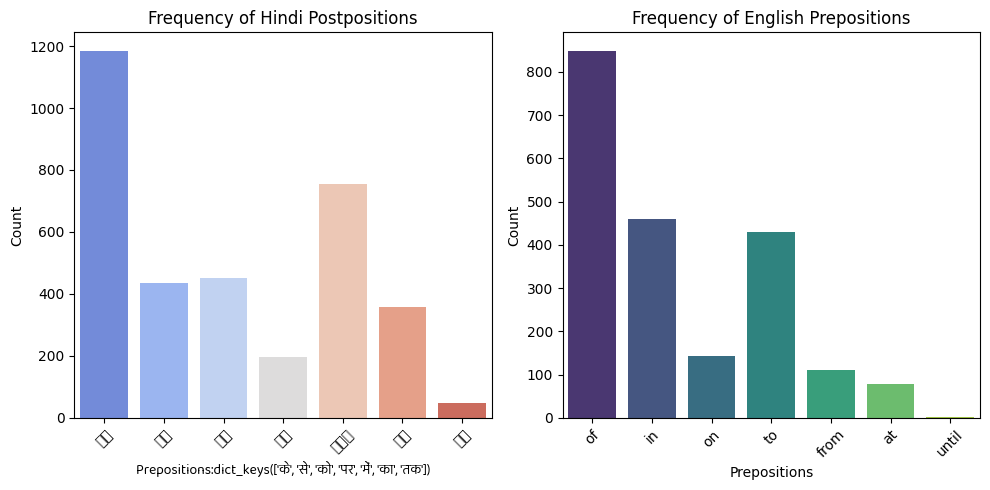

In [16]:
# Frequency analysis for postpositions and prepositions
from collections import Counter
import matplotlib.font_manager as fm
fontpath = 'hindi-fonts/Baloo2-Regular.ttf'
prop = fm.FontProperties(fname=fontpath)

# Extract postpositions from Hindi and prepositions from English
def extract_tokens_by_list(sentence, token_list):
    return [word for word in sentence.split() if word in token_list]

hindi_postpositions = ['में', 'से', 'पर', 'को', 'तक', 'के', 'का']
english_prepositions = ['in', 'from', 'on', 'to', 'until', 'of', 'at']

data['Hindi_Postpositions'] = data['Hindi'].apply(lambda x: extract_tokens_by_list(x, hindi_postpositions))
data['English_Prepositions'] = data['English'].apply(lambda x: extract_tokens_by_list(x, english_prepositions))

# Count frequencies
postposition_counts = Counter([p for sublist in data['Hindi_Postpositions'] for p in sublist])
preposition_counts = Counter([p for sublist in data['English_Prepositions'] for p in sublist])

# Visualization: Bilingual Postposition and Preposition Frequencies
plt.figure(figsize=(10, 5))

# Postpositions
plt.subplot(1, 2, 1)
sns.barplot(x=list(postposition_counts.keys()), y=list(postposition_counts.values()), palette="coolwarm")
plt.title("Frequency of Hindi Postpositions")
plt.xlabel(f"Prepositions:{postposition_counts.keys()}", fontproperties=prop)
plt.ylabel("Count")
plt.xticks(rotation=45)

# Prepositions
plt.subplot(1, 2, 2)
sns.barplot(x=list(preposition_counts.keys()), y=list(preposition_counts.values()), palette="viridis")
plt.title("Frequency of English Prepositions")
plt.xlabel("Prepositions")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("frequency_comparison.png")
plt.show()


c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2351 (\N{DEVANAGARI LETTER YA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 2366 (\N{DEVANAGARI VOWEL SIGN AA}) missing from current font.
  fig.canvas.draw()
c:\Users\nnadg\AppData\Local\Programs\P

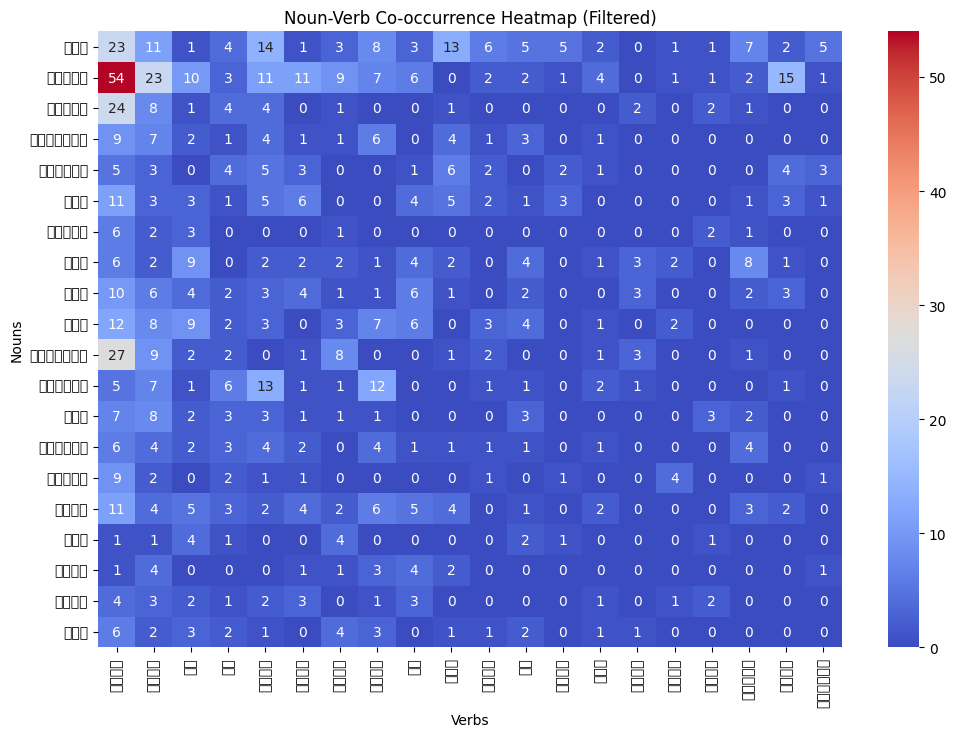

In [17]:
from collections import Counter
import numpy as np
import pandas as pd

# Step 1: Get most common nouns and verbs
def get_most_common_words(word_list, top_n=20):
    flat_list = [word for sublist in word_list for word in sublist]
    return [item[0] for item in Counter(flat_list).most_common(top_n)]

# Extract the most frequent nouns and verbs
most_common_nouns = get_most_common_words(data['Nouns'], top_n=20)
most_common_verbs = get_most_common_words(data['Verbs'], top_n=20)

# Step 2: Create co-occurrence matrix for frequent nouns and verbs
co_occurrence = np.zeros((len(most_common_nouns), len(most_common_verbs)))

for nouns, verbs in zip(data['Nouns'], data['Verbs']):
    for noun in nouns:
        for verb in verbs:
            if noun in most_common_nouns and verb in most_common_verbs:
                noun_idx = most_common_nouns.index(noun)
                verb_idx = most_common_verbs.index(verb)
                co_occurrence[noun_idx, verb_idx] += 1

# Step 3: Convert matrix to DataFrame for better plotting
co_occurrence_df = pd.DataFrame(
    co_occurrence,
    index=most_common_nouns,
    columns=most_common_verbs
)

# Step 4: Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_occurrence_df, annot=True, fmt=".0f", cmap="coolwarm", cbar=True)
plt.title("Noun-Verb Co-occurrence Heatmap (Filtered)")
plt.xlabel("Verbs")
plt.ylabel("Nouns")
plt.show()


In [25]:
print(aligned_data[0])

{'Original Hindi': 'नीदरलैंड के बाढ़ संभावित जिलों में, विशेष रूप से उत्तरी प्रांतों फ्रीसलैंड और ग्रोनिंगेन में, गांवों को पारंपरिक रूप से कम मानव निर्मित पहाड़ियों पर बनाया जाता था जिसे क्षेत्रीय डाइक-सिस्टम की शुरुआत से पहले टेरपेन कहा जाता था।', 'Translated English': 'In the vast streams of the Netherlands, especially in the northern regions of Fresland and Groningen, the villages were commonly built on the small man - made hills that were called Taurpton, before the beginning of the regional sex-system.', 'Original English': 'In the flood-prone districts of the Netherlands, particularly in the northern provinces of Friesland and Groningen, villages were traditionally built on low man-made hills called terpen before the introduction of regional dyke-systems.'}


In [26]:
print(data.head(5))

   index                                            English  \
0      0  In the flood-prone districts of the Netherland...   
1      1  Group A Group B The top five run scorers (tota...   
2      2  The final finished as a draw, with Essex winni...   
3      3  These traits—establishment of a working method...   
4      4  Its two most important members, Britain and Fr...   

                                               Hindi            scores  mean  \
0  नीदरलैंड के बाढ़ संभावित जिलों में, विशेष रूप ...  [90, 90, 79, 81]  85.0   
1  ग्रुप ए ग्रुप बी शीर्ष पांच रन स्कोरर (कुल रन)...  [95, 95, 87, 89]  91.5   
2  मैच की पहली पारी में बढ़त हासिल करने के बाद, ए...  [95, 95, 70, 60]  80.0   
3  ये विशेषताएं-कला का अभिन्न अंग कार्य प्रणाली क...  [90, 90, 78, 78]  84.0   
4  इसके दो सबसे महत्वपूर्ण सदस्य, ब्रिटेन और फ्रा...  [90, 90, 88, 86]  88.5   

                                            z_scores    z_mean  \
0  [0.10844457902530406, 0.17855383580414114, 0.6...  0.399822   
1  [0.53

In [ ]:
final_db = data.drop(columns=['scores', 'mean', 'z_scores', 'z_mean', 'Idioms', 'Idiom_Translations', 'Nouns_Verbs'])

In [30]:
final_db.to_csv('en_hi_dataset.tsv', sep='\t')

In [28]:
nlp_en = stanza.Pipeline('en', processors='tokenize,pos')
nlp_hi = stanza.Pipeline('hi', processors='tokenize,pos')

# Function to calculate verb positions in a sentence
def get_verb_positions(sentence, nlp):
    doc = nlp(sentence)
    verb_positions = []
    for sent in doc.sentences:
        for i, word in enumerate(sent.words):
            if word.upos == "VERB":  # Check if the word is a verb
                verb_positions.append(i + 1)  # Position is 1-based
    return verb_positions

# Collect all verb positions for English and Hindi
english_verb_positions = []
hindi_verb_positions = []

for _, row in data.iterrows():
    english_verb_positions.extend(get_verb_positions(row['English'], nlp_en))
    hindi_verb_positions.extend(get_verb_positions(row['Hindi'], nlp_hi))

# Calculate overall averages
avg_verb_position_english = sum(english_verb_positions) / len(english_verb_positions) if english_verb_positions else 0
avg_verb_position_hindi = sum(hindi_verb_positions) / len(hindi_verb_positions) if hindi_verb_positions else 0

print(f"Average position of verbs in English sentences: {avg_verb_position_english}")
print(f"Average position of verbs in Hindi sentences: {avg_verb_position_hindi}")

2024-11-27 22:05:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-27 22:05:06 INFO: Downloaded file to C:\Users\nnadg\stanza_resources\resources.json
2024-11-27 22:05:06 WARNING: Language en package default expects mwt, which has been added
2024-11-27 22:05:06 INFO: Loading these models for language: en (English):
| Processor | Package         |
-------------------------------
| tokenize  | combined        |
| mwt       | combined        |
| pos       | combined_charlm |

2024-11-27 22:05:06 INFO: Using device: cpu
2024-11-27 22:05:06 INFO: Loading: tokenize
2024-11-27 22:05:06 INFO: Loading: mwt
2024-11-27 22:05:06 INFO: Loading: pos
2024-11-27 22:05:07 INFO: Done loading processors!
2024-11-27 22:05:07 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with downloa

Average position of verbs in English sentences: 15.804136766568172
Average position of verbs in Hindi sentences: 21.74718275355218
